# NPoS Economics V3: Staking Stickiness & Slashing 
### Eray Sabancilar, Web3 Foundation, February 4, 2020

HackMD link to the write up below that is easier to read:
https://hackmd.io/ur28e_7DQUKte9YWpH-PBg?view


## Main Asumptions
- A Model with validators nominating only themselves. 
- There is no election of validators, i.e., all validators are assumed to be online all the time.
- Initial staking bootstrapped from Kusama genesis accounts. 
- We take into account slashing due to unresponsiveness and equivocation using two independent random processes with small probabilities of occurances, $p_u, p_e$, where $p_e < p_u \ll 1$. 
- No transaction or commission fees.
- Adjusting stakes on a period longer than a day, whose time is determined by a random process with probability $p_s \sim 1/7$.
- Closed system where no external wealth is injected into the system.

## Introduction
In this notebook, we describe a microeconomic model of the NPoS agents (nominators and validators). We design a deterministic dynamic model to simulate NPoS economics and make use of the Kusama genesis balance data to set the initial conditions. The accompanying implemention is given in this jupyter notebook.

We want to answer the following questions with this version of the NPoS economic model:
1. Does the staking rate, $x$, maintain a reasonable value over time, e.g., $x \sim 0.5$?
2. How do inflation, interest rate and staking/liquidity of dots evolve?
3. How does the staking rate and its volatility change over time? 
4. How do validator revenues evolve? Do they ever shrink to zero?
5. How is the wealth distributed over time? Do we observe accumulation of wealth?
6. Does the staking stickiness affect the overall dynamics? Does it lead to slower equilibrium of the state variables into their steady state values? Does it affect the wealth distribution?
7. How does slasing affect the evolution of the state variables? Does it affect the time scale to reach the equilibrium state?

### Model Assumptions
1. Basic assumptions:
   - Time is discrete, $t = 0,1,2,...$. 
   - The smallest time scale is an era, which is assumed to be a day long.
   - All nominators are independent. 
2. The nominators are the validators and only back themselves.
3. The half of the balance of the each account at genesis is assumed to be staked initially, i.e., the staking rate, $x(t)$, at the initial state is $x(t=0) \equiv x_0 = 0.5$. The distribution of stakes are bootstrapped from the Kusama account balances at genesis.
4. Payouts go to liquid accounts, whereas the stakes remain in the bonded (chill) account up to a few months.
5. The wealth is assumed to be not compounded since payouts are not automatically staked. Even if it is compounded, the effect is very small over the time scale of a few years since the expected interest rate is $\lesssim 0.2$ on average.
6. The payout to nominator $n$ is given by $P_n(x(t),t) = d_n(t)~r(x(t))$, where $d_n(t)$ is the stake of nominator $n$ and $r(x(t))$ is the daily interest rate.
    - The annual nominal interest rate is: $r^{\rm ann}(x(t)) = I_{NPoS}^{\rm ann}(x(t))/x(t)$
    - The annual inflation rate in terms of the staking rate, $x$, is:
    \begin{align}
    I_{NPoS}^{\rm ann}(x) = \begin{cases}
    I_0 + x\Big(r_{ideal} - I_0/\chi_{ideal}\Big)
    &\text{for } 0<x\leq \chi_{ideal}\\
    I_0 + (r_{ideal}\cdot \chi_{ideal} - I_0)\cdot 2^{(\chi_{ideal}-x)/d_{shift}}
    &\text{for } \chi_{ideal} < x \leq 1
    \end{cases},
    \end{align}
    where $I_0=0.025$, $\chi_{ideal}=0.5$, $r_{ideal}=0.2$ and $d_{shift}=0.05$.
    - The daily rates are related to the annual ones via a simple rescaling, $r = r^{\rm ann}/365$, assuming no compounding.
7. Nominator stakes are slashed if the validators that they back misbehave, namely for unresponsiveness or equivocation. We model the total slashing of the nominator $n$ in the era $T$, $S_n(t)$, in terms of unresponsiveness and equivocation as
\begin{align}
S_n(t) = \left(U_n f_u + E_n f_e \right) d_n(t) ,
\end{align}
where for unresponsiveness and equivocation, we respectively have
\begin{align}
U_n &\sim Bernoulli(p_u), \qquad f_u = 0.05 \min\left[\frac{3(k_u-1)}{N_n},1 \right] ,
\\
E_n &\sim Bernoulli(p_e) , \qquad f_e = \min\left[\left(\frac{3k_e}{N_n}\right)^2,1 \right].
\end{align}
Here, $N_n$ is the number of nominators, $k_u$ and $k_e$ are the total number of unreponsiveness and equivocation in a given era, respectively, and we assume that $p_e < p_u \ll 1$ since we expect equivocation misbehavior to be rare. In what follows, we set $p_u = 1/14$ and $p_e = 1/60$ so that unresponsiveness occurs once every other week whereas equivocation occurs roughly once every other month.
8. The wealth process of a nominator depends on the wealth and the revenue from the previous era only since we assume a closed system with no injection of external funds, and the slashing:
    - $W_n(x(t),t) = W_n(x(t-1),t-1) + d_n(t-1) ~ r(x(t-1)) - S_n(t-1)$.
    - The wealth is in nominal terms, i.e., the effect of inflation is not taken into account at this point yet.
9. A nominator is assumed to make a staking decision based on a comparasion of the real return with the opportunity cost of capital.
    - The annual opportunity cost of capital, $R_{\rm opp}^{\rm ann}$, can be calculated, e.g., using a market cap weighted real return of a cryptocurrency portfolio.
10. At the end of every era, nominator $n$ first decides whether to update the stake or not based on a random process, which roughly corresponds to updating stakes once a week. We model stickiness in staking decision with a Bernoulli random variable with probability $p_s = 1/7$, $Update_n \sim Bernoulli(p_s)$:
    - Update stakes if $Update_n = 1$.
    - Keep the stakes same if $Update_n = 0$.
11. If $Update_n = 1$ then nominator $n$  makes a staking decision as follows:
    - If $r(x(t-1)) = R_{\rm opp}$, keep stakes the same.
    - If $r(x(t-1)) > R_{\rm opp}$, increase stakes.
    - If $r(x(t-1)) < R_{\rm opp}$, decrease stakes.
12. A simple staking rate model that captures these properties is: 
$d_n(t) = d_n(t-1) + \alpha~Update_n ~ W_n(x(t),t)~[r(x(t-1)) - R_{\rm opp}]$
where $\alpha>1$ is a parameter measuring how fast the staking is adjusted, and we impose the following conditions to make sure the staking is bounded within the total wealth of a nominator: 
If $d_n(t) < 0$, $d_n(t) = 0$, and
If $d_n(t) > W_n(x(t),t)$, $d_n(t) =  W_n(x(t),t)$. 
13. We use the Gini coefficient $G \in [0,1]$ to assess the wealth inequality in the network, a computationally efficient version of which is defined for a ranked vector $W_n(x(t),t)$ as:
$G(t) =  \frac{\sum_{i=1}^{N_n}(2i - N_n - 1)W_i(x(t),t)}{N_n\sum_{i=1}^{N_n} W_i(x(t),t)}$,
where $N_n$ is the number of nominators.

### Simulation Specifications for the Nominator Staking & Wealth Processes
1. Set the initial stake distribution of nominators to the half of the genesis account distribution, i.e., assume everybody with an account nominates and stakes half of their initial wealth.
2. At $t=0$, calculate:
    - Initial wealth: $W_n(t=0) = W_n^0$ from the genesis balances.
    - Initial staking: $d_n(t=0) =  0.5 W_n^0$.
    - Initial interest rate: $r(x(t=0)) = r(x_0 = 0.5)$.
    - Set the opportunity cost of capital: $R_{\rm opp} = 0.05/365$.
3. At any time $t$:
    - Calculate wealth: $W_n(x(t),t)$.
    - Check the staking conditions, i.e., first the updating decision, and then, the adjusting decision, and finally execute the decision.
    - Calculate stake: $d_n(t)$.
    - Calculate staking rate: $x(t)$.
    - Calculate inflation rate: $I_{NPoS}(x(t))$.
    - Calculate nominal interest rate: $r(x(t))$.
    - Store nominator related variables.
4. Run the model upto 20 years $T = 365 \times 20$.
5. Report the time series of $x(t), r^{\rm ann}(x(t)), G(t)$.


## Parameters

| Parameters                  | Values                                        |
| --------                    | --------                                      | 
| Initial Nominator Wealths    | $w_0$: Taken from Kusama Genesis              | 
| Fraction of Initial Stakes  | $f_0 = 0.5$                                   |
| Inflation Parameters        | $I_0 = 0.025$, $\chi_{\rm ideal} = 0.5$, $r_{\rm ideal} = 0.2$, $d_{\rm shift} = 0.05$| 
| Era                         | $t=1$ day                              |
| Total Time                  | $T = 20$ years                         |
| Opportunity Cost of Capital | $R_{\rm opp}^{\rm ann} = 0.05$         |
| Staking Adjustment Speed    | $\alpha = 100$                         | 
| Stickiness Probability      | $p_s = 1/7$ (~once a week)             |
| Unresponsiveness Probability| $p_u = 1/14$ (~once every other week)  |
| Equivocation Probability    | $p_e = 1/60$ (~once every other month) |

## 1. Kusama Genesis Balances

### 1.1. Importing Kusama Genesis Address & Balance Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import scipy as sp 
#import scipy.stats as sps 
#from statsmodels.distributions.empirical_distribution import ECDF

# Import data
data = pd.read_csv("kusamaGenesisBalances.csv")

# Convert balances into units of Kusamas
data['Balance'] = data['Balance']*(10**(-12))

# Reorder data by balance amounts
data = data.sort_values(by='Balance', ascending=False)
nAccounts = data.values.size/2
print("The number of all accounts at genesis is {}.".format(nAccounts))

# Total and median amounts in the balances
sumKSM = data["Balance"].sum()
print("The total amount in the balances is {} million Kusamas.".format(round(sumKSM/10**6,3)))
medianKSM = round(data["Balance"].median(),3)
print("The median account balance is {} Kusamas.".format(medianKSM))

The number of all accounts at genesis is 381.0.
The total amount in the balances is 3.433 million Kusamas.
The median account balance is 211.051 Kusamas.


### 1.2. Exploratory Data Analysis

In [2]:
# The first few rows of the sorted dataset
data.head(4)

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


In [3]:
# The last few rows of the sorted dataset
data.tail(4)

,Address,Balance
269,5HjgWVF8CuP3xMsBmg4SKfK8Wvbhi6xoREs63YKfwZMAqy2r,0.01
311,5HNNjonNAftjHTToLpf5iyYeir2NDYnBdcRiwyJkP4Ra76QW,0.01
310,5CAWmjDvXUxrwThznrsMy5WwpH714NwJcMirqXQifLXQw4Li,0.01
298,5G6GU1xmqxmLmPQ2L9pXtqNiRdcGG31cbq63mf3TU7Z4BPDU,0.01


Since 0.01 Kusama is not enough to do anything practical other than keeping a Kusama account, we drop those balances from the dataset.

In [4]:
# Indicies of balances without 0.01 Kusama
idx = data["Balance"].loc[data["Balance"] != 0.01].index 

# Data without 0.01 Kusama accounts
dataClean = data.loc[idx]

# Check the first and the last few rows of ordered balances
display(dataClean.head(4))
display(dataClean.tail(4))

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


,Address,Balance
193,5H1DvSQVg8wGHiiP2ugdHQQUU7TUNAcL7cg6XYsnAFCDz63f,5.276
232,5DLB96CJ62oWhfUiLNN36tM9KmpU789dW5qRzCB3PTg2VBYD,4.588
19,5EyErcfEJTjKJjE4tDiPZNyAhCAqpckkNPo9Ncjod8yhZr7Z,2.661
258,5C5CHDNR2mgsy48eopGp1BcZ29EYM5dxMBNEAe5VpX4cPjKY,0.825


In [5]:
# Number of accounts in the clean dataset
nAccountsClean = dataClean.values.size/2
print("The number of accounts at genesis with more than 0.01 KSM is {}.".format(nAccountsClean))
print("Thus, there are {} accounts with 0.01 KSM that we drop in what follows.".format(nAccounts - nAccountsClean))

The number of accounts at genesis with more than 0.01 KSM is 339.0.
Thus, there are 42.0 accounts with 0.01 KSM that we drop in what follows.


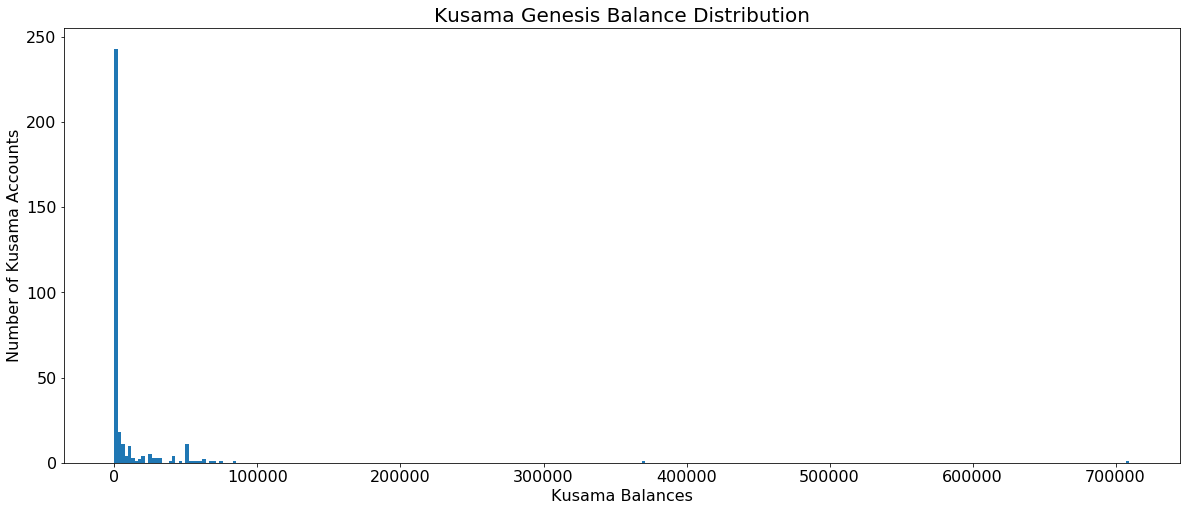

In [6]:
# Histogram of Kusama balances ignoring accounts with <= 0.01 KSM
plt.figure(figsize=(20,8))
plt.hist(dataClean["Balance"],300)
plt.xlabel('Kusama Balances',fontsize = 16)
plt.ylabel('Number of Kusama Accounts',fontsize = 16)
plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('KusamaGenesisBalances.pdf')

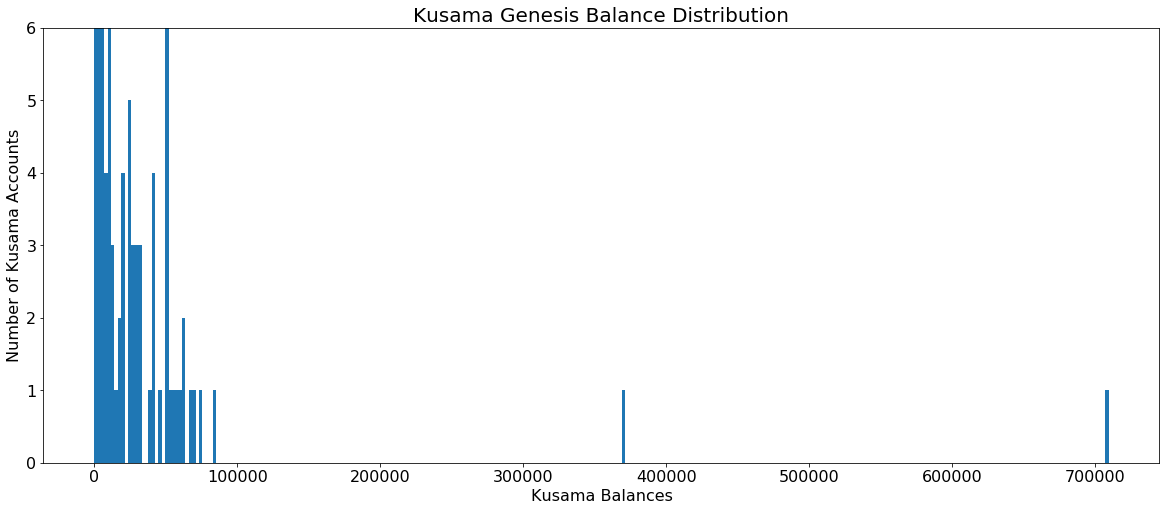

In [7]:
# Zooming into the figure
plt.figure(figsize=(20,8))
plt.hist(dataClean["Balance"],300)
plt.xlabel('Kusama Balances',fontsize = 16)
plt.ylabel('Number of Kusama Accounts',fontsize = 16)
plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,6])
plt.show()

In [8]:
#outlierShare
round((dataClean["Balance"][1]+dataClean["Balance"][2])*100/sumKSM,2)

12.22

We observe two outlier account balances with 709,346.898 & 369,340.969 KSM, whereas the lowest balance has 0.825 KSM. The largest two balances hold 12.22 % share of the whole Kusamas at genesis.

# 2. Initial Conditions

In [9]:
# Initial nominator wealth
w_0 = dataClean['Balance'].values
# Fraction of stakes from the Kusama genesis balances
f_0 = 0.5
# Initial staking
d_0 = f_0*w_0
# Inflation parameters
I_0 = 0.025 
chi_ideal = 0.5
r_ideal = 0.2
d_shift = 0.05
# Total time length
year = 20
T = 365*year
# Annual opportunity cost of capital
R_opp = 0.05
# Staking adjustment speed
alpha = 100
# Staking stickiness parameter: update roughly once a week
p_s = 1/7
# Unresponsiveness parameter: occurs roughly once every other week
p_u = 1/14
# Equivocation parameter: occurs roughly once every other month
p_e = 1/60

# 3. Function Definitions

## 3.1. Inflation and Interest Rates 

In [10]:
# Annual inflation rate as a function of the staking rate x
# ->Input parameters:
# I_0: inflation 
# chi_ideal: ideal staking rate
# r_ideal: ideal interest rate
# d_shift: shift parameter
# Input variable:
# x: staking rate as a number
# Output->:
# annualInflation: annual inflation rate
def annualInflation(I_0, chi_ideal, r_ideal, d_shift, x):
    if 0 <= x <= chi_ideal:
        I = I_0 + (r_ideal - I_0/chi_ideal)*x
    if chi_ideal < x <= 1:
        I = I_0 + (r_ideal*chi_ideal - I_0)*2**((chi_ideal - x)/d_shift)
    return I

# Annual interest rate
# ->Input parameters: I_0, chi_ideal, r_ideal, dinf
# Input variable:
# x: staking rate as a number
# Output->:
# annualInterest: annual inflation rate
def annualInterest(I_0, chi_ideal, r_ideal, d_shift, x):
    if 0<= x < 0.00001:
        r = 2.62
    else:
        r = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x)/x
    return r

## 3.2. Plot of Inflation and Interest Rates

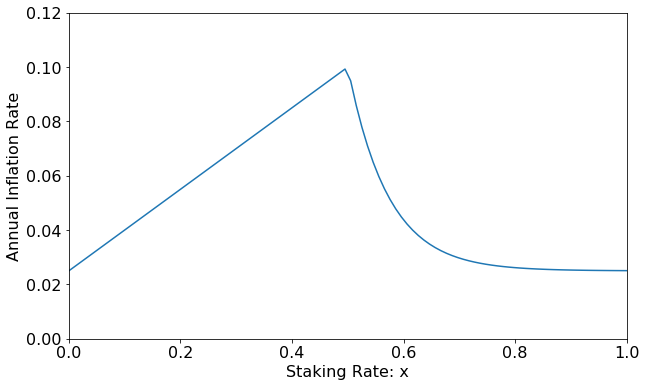

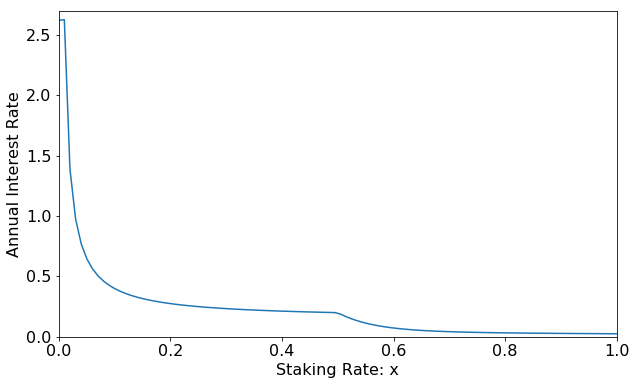

In [11]:
# Plot the annual NPoS inflation and interest rate curves
xlin = np.linspace(0, 1, 100, endpoint=True)
Ilin = np.zeros(len(xlin))
rlin = np.zeros(len(xlin))
for i in range(0,len(xlin)):
    Ilin[i] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, xlin[i])
    rlin[i] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, xlin[i])

plt.figure(figsize=(10,6))
plt.plot(xlin, Ilin)
plt.xlabel('Staking Rate: x',fontsize=16)
plt.ylabel('Annual Inflation Rate',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
axes.set_ylim([0,0.12])
axes.set_xlim([0,1])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(xlin, rlin)
plt.xlabel('Staking Rate: x',fontsize=16)
plt.ylabel('Annual Interest Rate',fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
axes.set_ylim([0,2.7])
axes.set_xlim([0,1])
plt.show()

## 3.2. NPoS Economic Model

In [12]:
# NPoSEcononomics function calculates nominal wealth, return, staking process of a nominator 
# as well as the staking, inflation and interest rates in each era t
def NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift, w_0, d_0, T, R_opp, alpha, p_s, p_u, p_e): 
    
    # Number of Nominators
    N_n = w_0.size
    # Pre-allocate w, d, R, I, r, x matrices
    # Nominal wealth of a nominator
    w = np.zeros((T+1,N_n))
    # Nominator stake
    d = np.zeros((T+1,N_n))
    # Nominal retun on stake
    R = np.zeros((T+1,N_n))
    # Real return on stake
    R_real = np.zeros((T+1,N_n))
    # Inflation rate
    I = np.zeros((T+1,1))
    # Interest rate
    r = np.zeros((T+1,1))
    # Staking rate
    x = np.zeros((T+1,1))
    # Unit vector of size equal to the number of nominators
    idN = np.ones((1,N_n))
    # Vector of zeros of size equal to the number of nominators
    zeroN = np.zeros((1,N_n))
    # Nominator slashing
    s = np.zeros((T+1,N_n))
                  
    # Set initial values
    w[0,:] = w_0
    d[0,:] = d_0
    x[0] = sum(d_0)/sum(w_0)
    I[0] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x[0])
    r[0] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, x[0])
    
    # Update values of these matrices in time
    t = 1
    while t <= T:
        # Unresponsiveness process determined by a Bernoulli variable with probability p_u
        u = np.random.binomial(1, p_u,(1,N_n))
        # Number of unresponsiveness per era
        k_u = np.sum(u)
        # Slashing fraction for unresponsiveness
        f_u = 0.05*min((3*(k_u-1)/N_n),1)
        
        # Equivocation process determined by a Bernoulli variable with probability p_e
        e = np.random.binomial(1, p_e,(1,N_n))
        # Number of unresponsiveness per era
        k_e = np.sum(e)
        # Slashing fraction for unresponsiveness
        f_e = min(((3*k_e/N_n)**2),1)
        
        # Slashing at time t-1
        s[t-1,:] = np.multiply(u*f_u + e*f_e,d[t-1,:])
        # No slashing at genesis
        s[0,:] = np.zeros((1,N_n))
        
        # Calculate the wealth at time t, note the conversion from annual to daily interest rate
        w[t,:] = w[t-1,:] + d[t-1,:]*(r[t-1]/365) - s[t-1,:]
        # Set wealth to zero if it has less than 0.01 KSM
        for i in range(0,N_n):
            if w[t,i] <= 0.01:
                w[t,i] = 0
        # Calculate the nominal daily return at time t from staking at time t-1
        #R[t,:] = np.true_divide(w[t,:] - w[t-1,:],w[t-1,:])
        # Calculate the real daily return
        #R_real[t,:] =  ((idN + R[t,:])/(1 + I[t-1]/365)) - idN
        
        # Staking decision stickiness process determined by a Bernoulli variable with probability p_s
        update = np.random.binomial(1, p_s,(1,N_n))
        # Update the stake based on the comparison of the interest rate with the opportunity cost of capital
        d[t,:] = d[t-1,:] + alpha*np.multiply(update,np.multiply(w[t,:],(r[t-1]/365 - (R_opp/365)*idN)))
        # Boundary conditions for d_t
        for i in range(0,w_0.size):
            if np.sign(d[t,i]) == -1:
                d[t,i] = 0
            if np.sign(d[t,i] - w[t,i]) == 1:
                d[t,i] = w[t,i]
            if w[t,i] == 0:
                d[t,i] = 0
        # Calculate the staking rate
        x[t] = sum(d[t,:])/sum(w[t,:])
        # Calculate the inflation rate
        I[t] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x[t])
        r[t] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, x[t])
        # Switch to the next time step
        t = t + 1
    return w, R, R_real, d, x, I, r

In [13]:
# Run the NPoSEconomics function V1: -> Set p_s = 1, p_u = P_e = 0 in V2 
M1 = NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift, w_0, d_0, T, R_opp, alpha,1 , 0, 0)
w1 = M1[0]
#R1 = M1[1]
#R_real1 = M1[2]
d1 = M1[3]
x1 = M1[4]
I1 = M1[5]
r1 = M1[6]
t = np.linspace(0, T, T+1)

In [14]:
# Run the NPoSEconomics function V2, with p_u = P_e = 0 
M2 = NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift, w_0, d_0, T, R_opp, alpha, p_s, 0, 0)
# Save the output
w2 = M2[0]
#R2 = M2[1]
#R_real2 = M2[2]
d2 = M2[3]
x2 = M2[4]
I2 = M2[5]
r2 = M2[6]
t = np.linspace(0, T, T+1)

In [15]:
# Run the NPoSEconomics function V3
M3 = NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift, w_0, d_0, T, R_opp, alpha, p_s, p_u, p_e)
# Save the output
w3 = M3[0]
#R3 = M3[1]
#R_real3 = M3[2]
d3 = M3[3]
x3 = M3[4]
I3 = M3[5]
r3 = M3[6]
t = np.linspace(0, T, T+1)

## 3.3. Gini Coefficient of Wealth Inequality

In [16]:
# Calculate the time series of the Gini coffecient in order to observe the evolution of 
# the inequality of wealth among nominators
# ->Input parameter:
# wealth: t x n time series of matrix of the wealth of nominators 
# <-Output: 
# G: The time series of the Gini coefficient
def Gini(wealth):
    # Calculate the number of time periods
    N_t = wealth.shape[0]
    # Calculate the number of nominators
    N_n = wealth.shape[1]
    # Preallocate the Gini coefficient time series vector
    G = np.zeros((N_t,1))
    # Calculate Gini coefficient for each time t
    for i in range(0,wealth.shape[0]):
        # Order wealth in ascending order
        wealth[i,:] = np.sort(wealth[i,:])
        # Calculate the rank
        rank = np.arange(1,wealth[i,:].shape[0]+1)
        G[i] = (np.sum((2*rank - N_n -1)*wealth[i,:]))/(N_n*np.sum(wealth[i,:]))
    return G

In [17]:
# Calculate the time series of the Gini Coefficient V1
G1 = Gini(w1)

In [18]:
# Calculate the time series of the Gini Coefficient V2
G2 = Gini(w2)

In [19]:
# Calculate the time series of the Gini Coefficient V3
G3 = Gini(w3)

## 3.3. Summary Plots

In [20]:
# summaryPlots function produces the time series plots of the staking rate, interest rate and Gini coefficient
def summaryPlots(t, x1, x2, x3, r1, r2, r3, G1, G2, G3):
    version = ['V1', 'V2', 'V3']
    plot_titles = ['Staking Rate', 'Annual Interest Rate', 'Gini Coefficient for Wealth Inequality']
    plot_variables1 = [x1, r1, G1]
    plot_variables2 = [x2, r2, G2]
    plot_variables3 = [x3, r3, G3]
    y_labels = ['Staking Rate: x(t)','Interest Rate: r(x(t))','Gini Coefficient: G(t)']
    for i in range(0,len(plot_titles)):
        plt.figure(figsize=(12,6))
        plt.plot(t, plot_variables1[i],"-b",linestyle='--', label="V1")
        plt.plot(t, plot_variables2[i],"-r",linestyle='-', label="V2: Staking Stickiness")
        plt.plot(t, plot_variables3[i],"-g",linestyle='-.', label="V3: Stickiness & Slashing")
        plt.legend(loc="best",fontsize=10)
        plt.title('NPoS Economics V3: ' + plot_titles[i],fontsize=16)
        plt.xlabel('Number of Days: t',fontsize=16)
        plt.ylabel(y_labels[i],fontsize=16)
        #axes = plt.gca()
        #axes.set_xlim([-10,T+1])
        #axes.set_ylim([0,1])
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.savefig(plot_titles[i] + '.pdf')

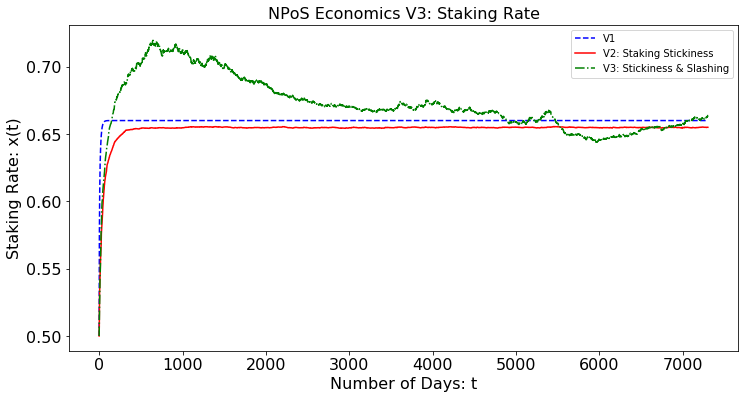

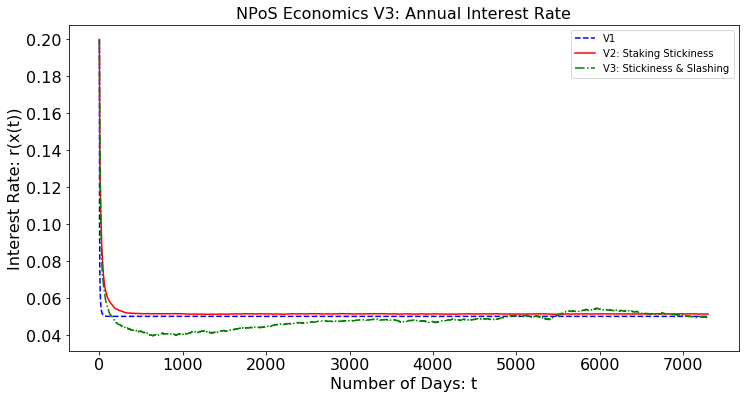

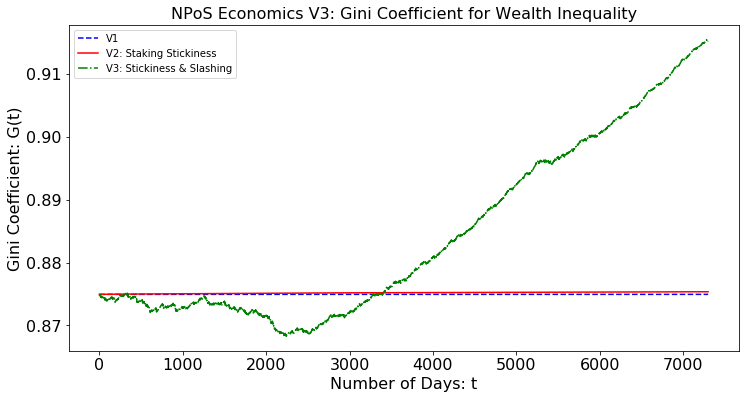

In [21]:
# Run the summary plots
summaryPlots(t, x1, x2, x3, r1, r2, r3, G1, G2, G3)

## Results V3
In the V3 of the model for the NPoS Economics, we study the effect of slashing. We assume validators only back themselves and there are no transaction or commission fees. In V2 we adopted a stickiness property such that nominators adjust their stakes roughly once a week, where we used a Bernoulli random variable with probability $p_s = 1/7$ to produce the desired frequency. In this version, V3, we also added slashing due to misbehaviors, namely, unresponsiveness and equivocation. We use Bernoulli random variables with probabilities $p_u = 1/14$ and $p_e = 1/60$ so that there is about one unresponsiveness in every other week and one equivocation in every other month. We implemented a stake adjusting mechanism that depends on the difference between a nominal interest rate and an opportunity cost of capital. We use Kusama genesis account balances to set up the initial conditions for the wealth and the stakes of each nominator. We summarize our basic results below:
1. Although we introduced a random mechanism for slashing, we do not observe a significant change in the distribution of wealth as can be seen from slowly increasing Gini coefficient, which evolves from $G = 0.88$ only to $0.9$.  Such a high value means that the initial wealth is distributed quite unevenly, and thus remains so in spite of the stake stickiness and slashing mechanisms.  
2. The staking rate, $x(t)$, evolves to a steady state value more slowly than the V2 and V1. We tested it with 20 years of run, and observe that staking rate reaches the steady state value of $x_{\rm steady state} \approx 0.66$ in the long run. In the short run, however, it remains stable around the value slightly above $x_{\rm steady state} \approx 0.66$. 
3. When a nominator is slashed, the staking rate decreases first, and then, the same nominator increases stakes again to achive a return above or at the opportunity cost of capital. Hence we observe a slight variation in the staking rate over time. As there are always some slashings, the staking rate remains above the steady state value.
4. Similar to the staking rate, interest rate reaches the state state value $r_{\rm steady~state} = 0.05$ in the long run ($T\sim 20$ years), and remains below the "market" value $R_{\rm opp} = 0.05$ in the short run.  
4. To summarize the effects of slashing:
    - Slashing makes the staking rate higher than its steady state value since slashed nominators immediately increase their stakes to achive a return close to the opportunity cost of capital.
    - The wealth distribution remains roughly the same, but making the wealtiest relatively wealthier, hence slashing has a small effect on the wealth distribution as long as it remains a rare event as we assumed.
    - In the long run, all the wealth is depricated due to slashings since in this model we assume nominators keep staking even though they are slashed. 
    - We note that unless slashing is an extremely rare event, it will reduce the wealth of the nominators in the long run. 